<a href="https://colab.research.google.com/github/nanunzoey/git_practice-1/blob/main/recommendatation_lightfm_goodreads_211014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Item 추천**

#### **1. 무엇을 하는 것인가?**
- 사용자와 item에 대한 정보를 바탕으로 **사용자가 선호할만한 item을 예측하는 것**이 목적입니다.
- 이를 위해 필요한 데이터는 아래 두 가지로 설명할 수 있습니다.
    - **1) 사용자가 현재 선호하는 item이 무엇인지**
    - **2) 그 사용자와 item의 각 특성이 무엇인지**    

#### **2. 적용 데이터 소개**
- 이전 데이터 탐색(EDA) 단계에서 전처리한 것을 사용합니다.
- 이 데이터에서 **유저가 어떤 책을 선호하는지** 객관적으로 판단할 수 있는, **가장 중요한 정보는 평점(rating)**입니다.
- **구하다**의 경우에는 **클릭 수와 구매, 장바구니, 찜하기 여부**를 중점으로 그 선호도를 측정할 계획입니다.
- **사용자가 선호할만한 item 추천**을 위해 **최종적으로 이용한** 데이터 특징(column)은 다음과 같습니다.
    - **book_id: 책 id**
    - is_eng: 책이 영문인지 여부
    - num_pages: 책 페이지 수
    - publication_year: 출판연도
    - publication_month: 출판한 달
    - publication_day: 출판한 날짜
    - **average_rating: 책의 평균 평점**
    -	**ratings_count: 책의 전체 평점 개수**
    - **text_reviews_count: 리뷰 개수**
    -	author_average_rating: 작가 평균 평점
    -	author_ratings_count: 작가 평점 개수
    -	author_text_reviews_count: 작가 리뷰 개수
    - **user_id: 사용자 id**
    -	**rating: 사용자가 매긴 책의 평점**    

## **Import Modules**

In [2]:
!pip install lightfm
!pip install scikit-optimize

     |████████████████████████████████| 310 kB 16.0 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=706137 sha256=0443b516e0edd80cd8ef4d29bbcf3e669feae64de3e49265be3d837cd76d194a
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm
     |████████████████████████████████| 100 kB 7.0 MB/s 


In [3]:
from google.colab import files
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
from skopt import forest_minimize

## **데이터 로드**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# file_path = "/content/drive/MyDrive/AIFFEL/해커톤3/모델 검증_토이데이터_211010"
book_path = '/content/drive/MyDrive/AIFFEL/해커톤3/미니해커톤_토이모델구현/데이터_goodreads/book_data_log.csv'
action_path = '/content/drive/MyDrive/AIFFEL/해커톤3/미니해커톤_토이모델구현/데이터_goodreads/action_data.csv'

book = pd.read_csv(book_path)
action = pd.read_csv(action_path)

In [6]:
print(book.shape)
print(action.shape)

(19723, 18)
(1313610, 4)


In [7]:
book.head()

,Unnamed: 0,title,author_name,book_id,url,is_ebook,is_eng,num_pages,publication_year,publication_month,publication_day,average_rating,to_read,ratings_count,text_reviews_count,author_average_rating,author_ratings_count,author_text_reviews_count
0,0,Vision of Sir Launfal and Other Poems,James Russell Lowell,16037549,https://www.goodreads.com/book/show/16037549-v...,0,1,4.394449,1887.0,11.0,1.0,3.83,2.197225,1.386294,0.693147,4.03,7.289611,5.068904
1,1,Fairy Tales: Dramolettes,Robert Walser,22466716,https://www.goodreads.com/book/show/22466716-f...,0,0,4.859812,2015.0,4.0,20.0,3.83,4.615121,3.637586,1.098612,4.02,9.245708,6.984716
2,2,Thirty Poems,Robert Walser,13447246,https://www.goodreads.com/book/show/13447246-t...,0,1,4.174387,2012.0,5.0,31.0,3.79,3.433987,3.688879,1.609438,4.02,9.245708,6.984716
3,3,Oppressive Light: Selected Poems by Robert Walser,Robert Walser,12740665,https://www.goodreads.com/book/show/12740665-o...,0,0,5.303305,2012.0,8.0,7.0,4.46,4.110874,3.295837,1.791759,4.02,9.245708,6.984716
4,5,The Cocktail Party,T.S. Eliot,926667,https://www.goodreads.com/book/show/926667.The...,0,0,5.252273,1964.0,3.0,18.0,3.71,6.318968,4.753590,2.564949,4.17,12.154553,8.681520


In [8]:
action.head()

,Unnamed: 0,user_id,book_id,rating
0,0,8842281e1d1347389f2ab93d60773d4d,1384,4
1,1,8842281e1d1347389f2ab93d60773d4d,1376,4
2,2,8842281e1d1347389f2ab93d60773d4d,30119,5
3,4,72fb0d0087d28c832f15776b0d936598,30119,3
4,5,ab2923b738ea3082f5f3efcbbfacb218,240007,4


## **데이터 전처리**

##### - 사용하지 않을 column 제거

In [9]:
book_data = book.drop(['Unnamed: 0', 'is_ebook', 'author_name', 'url'], axis=1)

In [10]:
action_data = action.drop(['Unnamed: 0'], axis=1)

##### - missing value & 중복 처리

In [11]:
book_data.dropna(inplace=True)
action_data.dropna(inplace=True)

In [12]:
book_data['num_pages'].replace(0, -1, inplace=True)
book_data['publication_year'].replace(0, 2100, inplace=True)

In [13]:
book_data.drop_duplicates(inplace=True)
action_data.drop_duplicates(inplace=True)

In [14]:
print(book_data.shape)
print(action_data.shape)

(19723, 14)
(1313610, 3)


##### - 데이터 분포 확인 및 outlier 처리

In [15]:
# book_data['publication_year'] = pd.to_numeric(book_data['publication_year'])
book_data['publication_year'].describe()

count    19723.000000
mean      2004.374537
std         11.509735
min       1803.000000
25%       2000.000000
50%       2007.000000
75%       2012.000000
max       2018.000000
Name: publication_year, dtype: float64

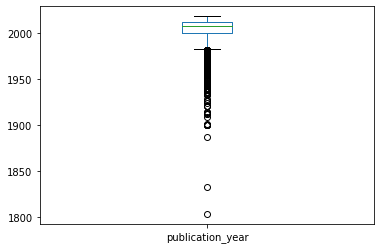

In [16]:
book_data['publication_year'].plot.box()

##### - categorical column 처리

In [17]:
book_data['ratings_count'].describe()

count    19723.000000
mean         3.571618
std          1.558912
min          0.000000
25%          2.484907
50%          3.401197
75%          4.442651
max         13.431059
Name: ratings_count, dtype: float64

In [18]:
# book_data['num_pages'] = pd.to_numeric(book_data['num_pages'])
book_data['num_pages'].describe()

count    19723.000000
mean         4.842049
std          0.846369
min         -1.000000
25%          4.394449
50%          4.727388
75%          5.379897
max          8.222285
Name: num_pages, dtype: float64

In [19]:
book_data = book_data.sort_values('book_id').reset_index(drop=True)

book_data.head()

,title,book_id,is_eng,num_pages,publication_year,publication_month,publication_day,average_rating,to_read,ratings_count,text_reviews_count,author_average_rating,author_ratings_count,author_text_reviews_count
0,The Complete Nonsense of Edward Lear,236,0,5.662960,1940.0,6.0,1.0,4.03,6.269096,5.774552,3.433987,4.04,9.622119,6.850126
1,A Was Once an Apple Pie,241,0,3.496508,2005.0,9.0,1.0,3.35,4.158883,5.049856,3.951244,4.04,9.622119,6.850126
2,The Puffin Book Of Nonsense Verse,244,1,5.662960,1996.0,10.0,3.0,4.04,4.189655,4.158883,1.945910,4.11,14.641536,10.975396
3,The Time of the Assassins: a Study of Rimbaud,254,0,5.081404,1962.0,1.0,17.0,3.95,3.496508,6.599870,4.007333,3.81,11.598672,8.634976
4,A Treasury of Kahlil Gibran,284,0,6.124683,1976.0,1.0,1.0,4.42,5.789960,5.384495,2.397895,4.15,12.354975,9.432844


In [20]:
book_final = book_data.drop('title', axis=1).copy()

In [21]:
# using pandas qcut method to convert fields into quantile-based discrete intervals
book_final['publication_year'] = pd.qcut(book_final['publication_year'], 20, duplicates='drop')

# rounding ratings to neares .5 score
book_final['average_rating'] = book_final['average_rating'].apply(lambda x: round(x*2)/2)

In [22]:
book_final.head()

,book_id,is_eng,num_pages,publication_year,publication_month,publication_day,average_rating,to_read,ratings_count,text_reviews_count,author_average_rating,author_ratings_count,author_text_reviews_count
0,236,0,5.662960,"(1802.999, 1982.0]",6.0,1.0,4.0,6.269096,5.774552,3.433987,4.04,9.622119,6.850126
1,241,0,3.496508,"(2003.0, 2005.0]",9.0,1.0,3.5,4.158883,5.049856,3.951244,4.04,9.622119,6.850126
2,244,1,5.662960,"(1995.0, 1998.0]",10.0,3.0,4.0,4.189655,4.158883,1.945910,4.11,14.641536,10.975396
3,254,0,5.081404,"(1802.999, 1982.0]",1.0,17.0,4.0,3.496508,6.599870,4.007333,3.81,11.598672,8.634976
4,284,0,6.124683,"(1802.999, 1982.0]",1.0,1.0,4.5,5.789960,5.384495,2.397895,4.15,12.354975,9.432844


In [23]:
# dummify categorical features
book_final = pd.get_dummies(book_final, columns=['average_rating', 'publication_year'])

In [24]:
book_final.sample(5)

,book_id,is_eng,num_pages,publication_month,publication_day,to_read,ratings_count,text_reviews_count,author_average_rating,author_ratings_count,author_text_reviews_count,average_rating_0.0,average_rating_1.0,average_rating_1.5,average_rating_2.0,average_rating_2.5,average_rating_3.0,average_rating_3.5,average_rating_4.0,average_rating_4.5,average_rating_5.0,"publication_year_(1802.999, 1982.0]","publication_year_(1982.0, 1990.0]","publication_year_(1990.0, 1995.0]","publication_year_(1995.0, 1998.0]","publication_year_(1998.0, 2000.0]","publication_year_(2000.0, 2002.0]","publication_year_(2002.0, 2003.0]","publication_year_(2003.0, 2005.0]","publication_year_(2005.0, 2006.0]","publication_year_(2006.0, 2007.0]","publication_year_(2007.0, 2008.0]","publication_year_(2008.0, 2009.0]","publication_year_(2009.0, 2010.0]","publication_year_(2010.0, 2012.0]","publication_year_(2012.0, 2013.0]","publication_year_(2013.0, 2014.0]","publication_year_(2014.0, 2015.0]","publication_year_(2015.0, 2016.0]","publication_year_(2016.0, 2018.0]"
6691,1178968,0,4.955827,1.0,1.0,1.791759,1.945910,0.693147,3.82,2.484907,1.386294,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6734,1192108,0,4.727388,1.0,1.0,1.791759,2.484907,1.386294,4.29,3.737670,1.945910,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1575,150266,0,6.142037,12.0,17.0,8.225235,6.175867,3.583519,4.35,8.643121,5.786897,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8460,1986053,0,4.204693,8.0,12.0,2.079442,2.484907,1.098612,3.94,5.484797,3.555348,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16864,22608141,1,3.761200,6.0,25.0,5.123964,2.197225,1.791759,4.25,5.209486,4.248495,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [25]:
action_final = action_data.copy()

In [87]:
action_final = action_final[action_final['rating'] != 0]
action_final.head()

,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,1384,4
1,8842281e1d1347389f2ab93d60773d4d,1376,4
2,8842281e1d1347389f2ab93d60773d4d,30119,5
3,72fb0d0087d28c832f15776b0d936598,30119,3
4,ab2923b738ea3082f5f3efcbbfacb218,240007,4


In [27]:
print(book_final.shape)
print(action_final.shape)

(19723, 40)
(1229059, 3)


## **CSR Matrix 생성**

##### - item dictionary 생성

In [28]:
df = book_data[['book_id', 'title']]
df.reset_index(inplace=True)

In [29]:
df

,index,book_id,title
0,0,236,The Complete Nonsense of Edward Lear
1,1,241,A Was Once an Apple Pie
2,2,244,The Puffin Book Of Nonsense Verse
3,3,254,The Time of the Assassins: a Study of Rimbaud
4,4,284,A Treasury of Kahlil Gibran
...,...,...,...
19718,19718,36387428,Lounaalla
19719,19719,36390749,Ocean Deep
19720,19720,36403877,Calling a Wolf a Wolf
19721,19721,36407928,Poezje


In [30]:
item_dict = {}

for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = df.loc[i,'title']

In [31]:
item_dict[36387428]

'Lounaalla'

##### - train, test 데이터셋 split -> csr matrix 생성

In [32]:
book_csr = csr_matrix(book_final.drop('book_id', axis=1).values)
book_csr

<19723x39 sparse matrix of type '<class 'numpy.float64'>'
	with 222583 stored elements in Compressed Sparse Row format>

In [33]:
action_final.shape

(1229059, 3)

In [34]:
action_sample = action_final.loc[action_final['user_id'].isin(random.sample(list(action_final['user_id'].unique()), k=30000))]

In [35]:
# interaction matrix
interaction = pd.pivot_table(action_sample, index='user_id', columns='book_id', values='rating')

# fill missing values with 0
interaction = interaction.fillna(0)

interaction.head()

book_id,234,236,241,244,254,284,285,286,289,290,291,292,448,459,462,484,676,1371,1372,1373,1374,1376,1377,1378,1381,1382,1383,1384,1387,1388,1392,1402,1403,1405,1407,1414,1416,1417,1420,1421,...,35663570,35668923,35673154,35691576,35693670,35704999,35752056,35784849,35834374,35835617,35887236,35894556,35897777,35905478,35919520,35960350,35991559,35994679,36011645,36038841,36056405,36059170,36064679,36070215,36075107,36096745,36118881,36122873,36126998,36150827,36232007,36241067,36263633,36274683,36282926,36350410,36365232,36392878,36392890,36417323
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000243c8e211fb3f359e4ff45ca899ea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00052f373c101767aca448f09a9b07e5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007c32f7f876a7b7704b3b0aeb5db07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000a9539c044b397780166167b1327b3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000adba19f8f49c25017d68c2a55d90f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
user_id = list(interaction.index)

user_dict = {}
counter = 0

for i in user_id:
  user_dict[i] = counter
  counter += 1

In [37]:
# convert to csr matrix
interaction_csr = csr_matrix(interaction.values)
interaction_csr

<30000x18295 sparse matrix of type '<class 'numpy.float64'>'
	with 137367 stored elements in Compressed Sparse Row format>

In [38]:
# train과 test를 위한 데이터를 나눈다
# test 시에는 train에 사용한 데이터를 사용하지 않고, 공정하게 평가하기 위함임
train_interaction_csr, test_interaction_csr = random_train_test_split(interaction_csr, test_percentage=0.2)

## **Model Train & Evaluation**

In [39]:
# 추천 모델을 정의
model = LightFM(loss='warp',
                random_state=2021,
                learning_rate=0.09,
                no_components=150,
                user_alpha=0.000005)

# 위에서 정의한 모델을 학습시킴
result = model.fit(train_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=True)

Epoch: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


In [40]:
# 추천 알고리즘 성능을 평가하기 위한 점수
# 1에 가까울수록 추천에 대한 신뢰도가 높다고 말할 수 있다
auc_train = auc_score(result, train_interaction_csr, num_threads=16).mean()
auc_test = auc_score(result, test_interaction_csr, num_threads=16).mean()

print('AUC Score for Train:', auc_train)
print('AUC Score for Test:', auc_test)

AUC Score for Train: 0.9999698
AUC Score for Test: 0.8842181


In [85]:
# 특정 유저가 선호하는 책 정보를 바탕으로 선호할만한 책을 추천해주는 함수
def sample_recommendation(user_id, user_dict, item_dict, threshold=0, nrec_items=5, show = True):
  n_users, n_items = interaction.shape
  user_idx = user_dict[user_id]

  scores = pd.Series(result.predict(user_idx, np.arange(n_items), item_features=book_csr))
  scores.index = interaction.columns
  scores = list(pd.Series(scores.sort_values(ascending=False).index))

  known_items = list(pd.Series(interaction.loc[user_id,:][interaction.loc[user_id,:] > threshold].index).sort_values(ascending=False))

  scores = [x for x in scores if x not in known_items]
  return_score_list = scores[0:nrec_items]

  known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
  scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

  if show == True:
      print ("User: " + str(user_id))
      print("Known Likes:")
      counter = 1
      for item in known_items:
          print(str(counter) + '- ' + item)
          counter += 1

      print("\nRecommended Items:")
      counter = 1
      for s in scores:
          print(str(counter) + '- ' + s)
          counter += 1

In [86]:
# random user를 한 명 고른다
random_user = random.sample(list(interaction.index), 1)

# 해당 유저가 선호하는 책 정보를 바탕으로, 5개의 선호할만한 책을 추천
sample_recommendation(random_user[0], user_dict, item_dict)

User: 3cb1c961c10302250fcade9ecdba9256
Known Likes:
1- Antologia poética

Recommended Items:
1- Pax Atomica: Poems
2- What Work Is
3- Odyssey
4- Ohayo Haiku
5- The Odyssey
